# Learning linear conservative system using a symplectic neural network

In [1]:
from utils import create_gif, generate_linear_hamiltonian_data, generate_linear_hamiltonian_trajectory
import torch 

torch.set_default_dtype(torch.float64)
torch.manual_seed(0)

# Generate a dataset of exact solutions of a linear Hamiltonian system
DIM = 100
TIMESTEP = torch.tensor([0.25])
NDATA = 1000

x0, x1 = generate_linear_hamiltonian_data(
    dim=DIM, 
    ndata=NDATA, 
    timestep=TIMESTEP,
)

### Initialize the Hamiltonian neural network (P-SympNet) using the StruPNET package

In [2]:
from strupnet import SympNet

sympnet = SympNet(
    dim=DIM,
    max_degree=2,
    layers=2*DIM,
    method='P',
)

### Train the Hamiltonian neural network using the Adams optimiser

In [3]:
NEPOCHS = 3000
LEARNING_RATE = 0.1
TOL = 1e-11

optimizer = torch.optim.Adam(sympnet.parameters(), lr=LEARNING_RATE)
mse = torch.nn.MSELoss()
for epoch in range(NEPOCHS):
    optimizer.zero_grad()    
    x1_pred = sympnet(x=x0, dt=TIMESTEP)
    loss = mse(x1, x1_pred)
    loss.backward()
    optimizer.step()
    if loss.item() < TOL:
        break
    if epoch % 100 == 0:
        print("Epoch: ", epoch, " Loss: ", loss.item())

print("Final loss value: ", loss.item())

/Users/bentapley/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch:  0  Loss:  0.06988186030664334
Epoch:  100  Loss:  8.080599721520473e-06
Epoch:  200  Loss:  3.273120114792409e-05
Epoch:  300  Loss:  3.785409607352297e-08
Epoch:  400  Loss:  5.583986833234348e-09
Epoch:  500  Loss:  2.676041655978783e-06
Epoch:  600  Loss:  6.360494660195183e-08
Epoch:  700  Loss:  4.718344947903142e-10
Epoch:  800  Loss:  1.3881132189599621e-10
Epoch:  900  Loss:  5.204821066630158e-11
Epoch:  1000  Loss:  3.168111379989685e-11
Epoch:  1100  Loss:  2.228658537407103e-11
Epoch:  1200  Loss:  1.631462234021772e-11
Epoch:  1300  Loss:  1.2242843139608827e-11
Final loss value:  9.97651347264658e-12


### Compare the prediction with the true solution

GIF saved as prediction.gif


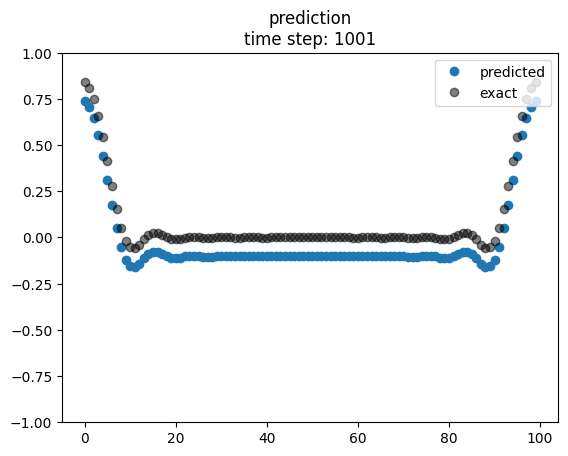

In [4]:
NSTEPS = 1000


z = torch.linspace(-1, 1, DIM)
p0, q0 = torch.zeros(DIM), torch.exp(-z**2*100)

true_sol = generate_linear_hamiltonian_trajectory(p0, q0, TIMESTEP, NSTEPS)

# get predicted solution
pred_sol = torch.zeros(NSTEPS + 1, 2*DIM)
pred_sol[0, :] = true_sol[0, :]
for i in range(NSTEPS):
    pred_sol[i+1, :] = sympnet(x=pred_sol[i, :], dt=TIMESTEP).detach()

create_gif(pred_sol[:, DIM:], exact_solution=true_sol[:, DIM:], title='prediction', duration=0.00001)
